In [1]:
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
df1 = pd.read_csv('3min_series.csv')
df2 = pd.read_csv('Средняя масса доли АПГ New.csv')
df3 = pd.read_csv('target.csv', sep=';')

Посмотрим данные

In [3]:
print(df1.info())
print(df2.info())
print(df3.info())
print(df1.describe())
print(df2.describe())
print(df3.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52269 entries, 0 to 52268
Data columns (total 19 columns):
Date                  52269 non-null object
Шум                   51327 non-null float64
Обратная ЭДС          51327 non-null float64
Ср.прир.напр.         49631 non-null float64
Сум.доз АПГ           51328 non-null float64
Board Temp. 1         50850 non-null float64
Board Temp. 2         50850 non-null float64
Board Temp. 3         50850 non-null float64
Board Temp. 4         50850 non-null float64
Board Temp. 5         50850 non-null float64
Board Temp. 6         50850 non-null float64
Board Temp. 7         50850 non-null float64
Board Temp. 8         50850 non-null float64
Board Temp. 9         50850 non-null float64
Board Temp. 10        50850 non-null float64
Board Face Temp. 1    50850 non-null float64
Board Face Temp. 6    50850 non-null float64
Board Deaf Temp. 1    50850 non-null float64
Board Deaf Temp. 6    50850 non-null float64
dtypes: float64(18), object(1)
memory

Ограничим данные по дате

In [4]:
df1['Date'] = pd.to_datetime(df1['Date'])
start_date = '31-07-2018'
end_date = '18-10-2018'
df1 = df1[(df1.Date >= start_date) & (df1.Date <= end_date)]
df2['Dateparse'] = pd.to_datetime(df2['Dateparse'])
df2 = df2[(df2.Dateparse >= start_date) & (df2.Dateparse <= end_date)]
df3.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3[(df3.Date >= start_date) & (df3.Date <= end_date)]

Приведем данные таблицы "3min_series.csv" к часовым промежуткам. Затем я могу воспользоваться данными из таблицы "Средняя масса доли АПГ New.csv" и посчитать итоговую массу АПГ.

In [5]:
times = pd.DatetimeIndex(df1.Date).round('H')

mean_for_col = []
cols = ['Шум', 'Обратная ЭДС', 'Ср.прир.напр.', 'Board Temp. 1', 'Board Temp. 2', 'Board Temp. 3',\
'Board Temp. 4', 'Board Temp. 5', 'Board Temp. 6', 'Board Temp. 7', 'Board Temp. 8', 'Board Temp. 9',\
'Board Temp. 10', 'Board Face Temp. 1', 'Board Face Temp. 6', 'Board Deaf Temp. 1', 'Board Deaf Temp. 6']

for col in cols:
    mean_for_col.append(df1.groupby([times])[col].mean().reset_index()[col].values)
    date = df1.groupby([times])[col].mean().reset_index()['Date']
    
grouped = pd.DataFrame(mean_for_col).T
grouped.columns = cols
grouped.index = date

grouped['Сум.доз АПГ'] = df1.groupby([times])['Сум.доз АПГ'].sum()

Добавим информацию по итоговой массе АПГ

In [6]:
grouped['total_mass_apg'] = grouped['Сум.доз АПГ'].values*df2['avg_mass_apg'].values

In [7]:
df3.isna().sum()

Date                 0
product_percents    33
dtype: int64

In [8]:
df3.dropna(subset=['product_percents'], inplace=True)

У нас очень много температурных измерений по ширине, особенно по длине ящика, посмотрим, как они ведут себя по отношению к друг другу 

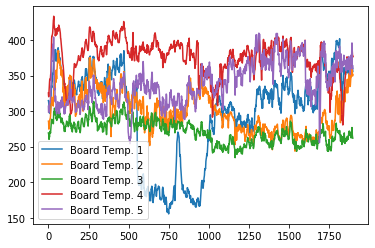

In [9]:
for col in grouped.columns[4:9]:
    plt.plot(grouped[col].values)
    plt.legend(['Board Temp. 1', 'Board Temp. 2', 'Board Temp. 3', 'Board Temp. 4', 'Board Temp. 5',])
    

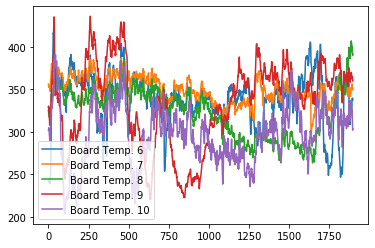

In [10]:
for col in grouped.columns[9:14]:
    plt.plot(grouped[col].values)
    plt.legend(['Board Temp. 6', 'Board Temp. 7','Board Temp. 8', 'Board Temp. 9', 'Board Temp. 10'])

Чтобы визуально было удобнее оценить кривые, я сделала 2 графика температур по длине ящика. Из графиков немного выбивается Board Temp. 1, предполагаю, что она находится в углу ящика, возможно, отдалена от нагревательных элементов. В целом температуры по длине ящика неравномерны. Если нужно дать рекомендации по процессу, возможно, уместно улучшить температурную гомогенность ящика.

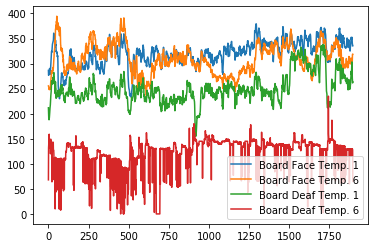

In [11]:
for col in grouped.columns[14:18]:
    plt.plot(grouped[col].values)
    plt.legend(['Board Face Temp. 1', 'Board Face Temp. 6', 'Board Deaf Temp. 1', 'Board Deaf Temp. 6'])

Температуры с датчиков с лицевой стороны имеют схожие значения, сильно отличается датчик 6 с тыльной стороны. Без информации по расположению датчиков относительно нагревательных элементов сложно оценить причину этого отклонения.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F09905A9C8>,
      dtype=object)

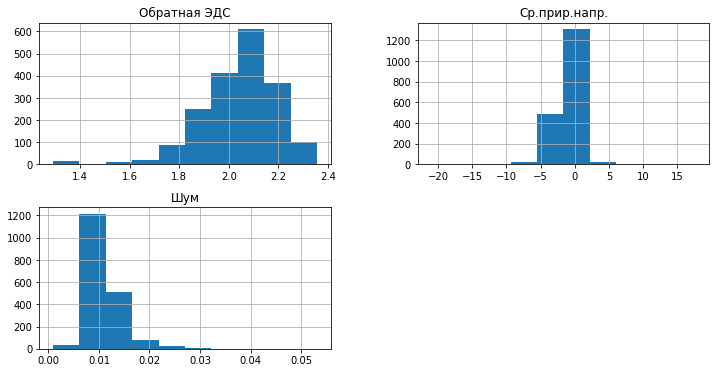

In [12]:
grouped[['Шум', 'Обратная ЭДС', 'Ср.прир.напр.']].hist(figsize=(12,6))

Объединим grouped с таргетом. Т.к. таргет контролировался дважды в сутки, многие данные останутся неиспользованными в последующем анализе.

In [13]:
final_df = pd.merge(grouped, df3, on = 'Date')

Посмотрим как распределены данные в новой df

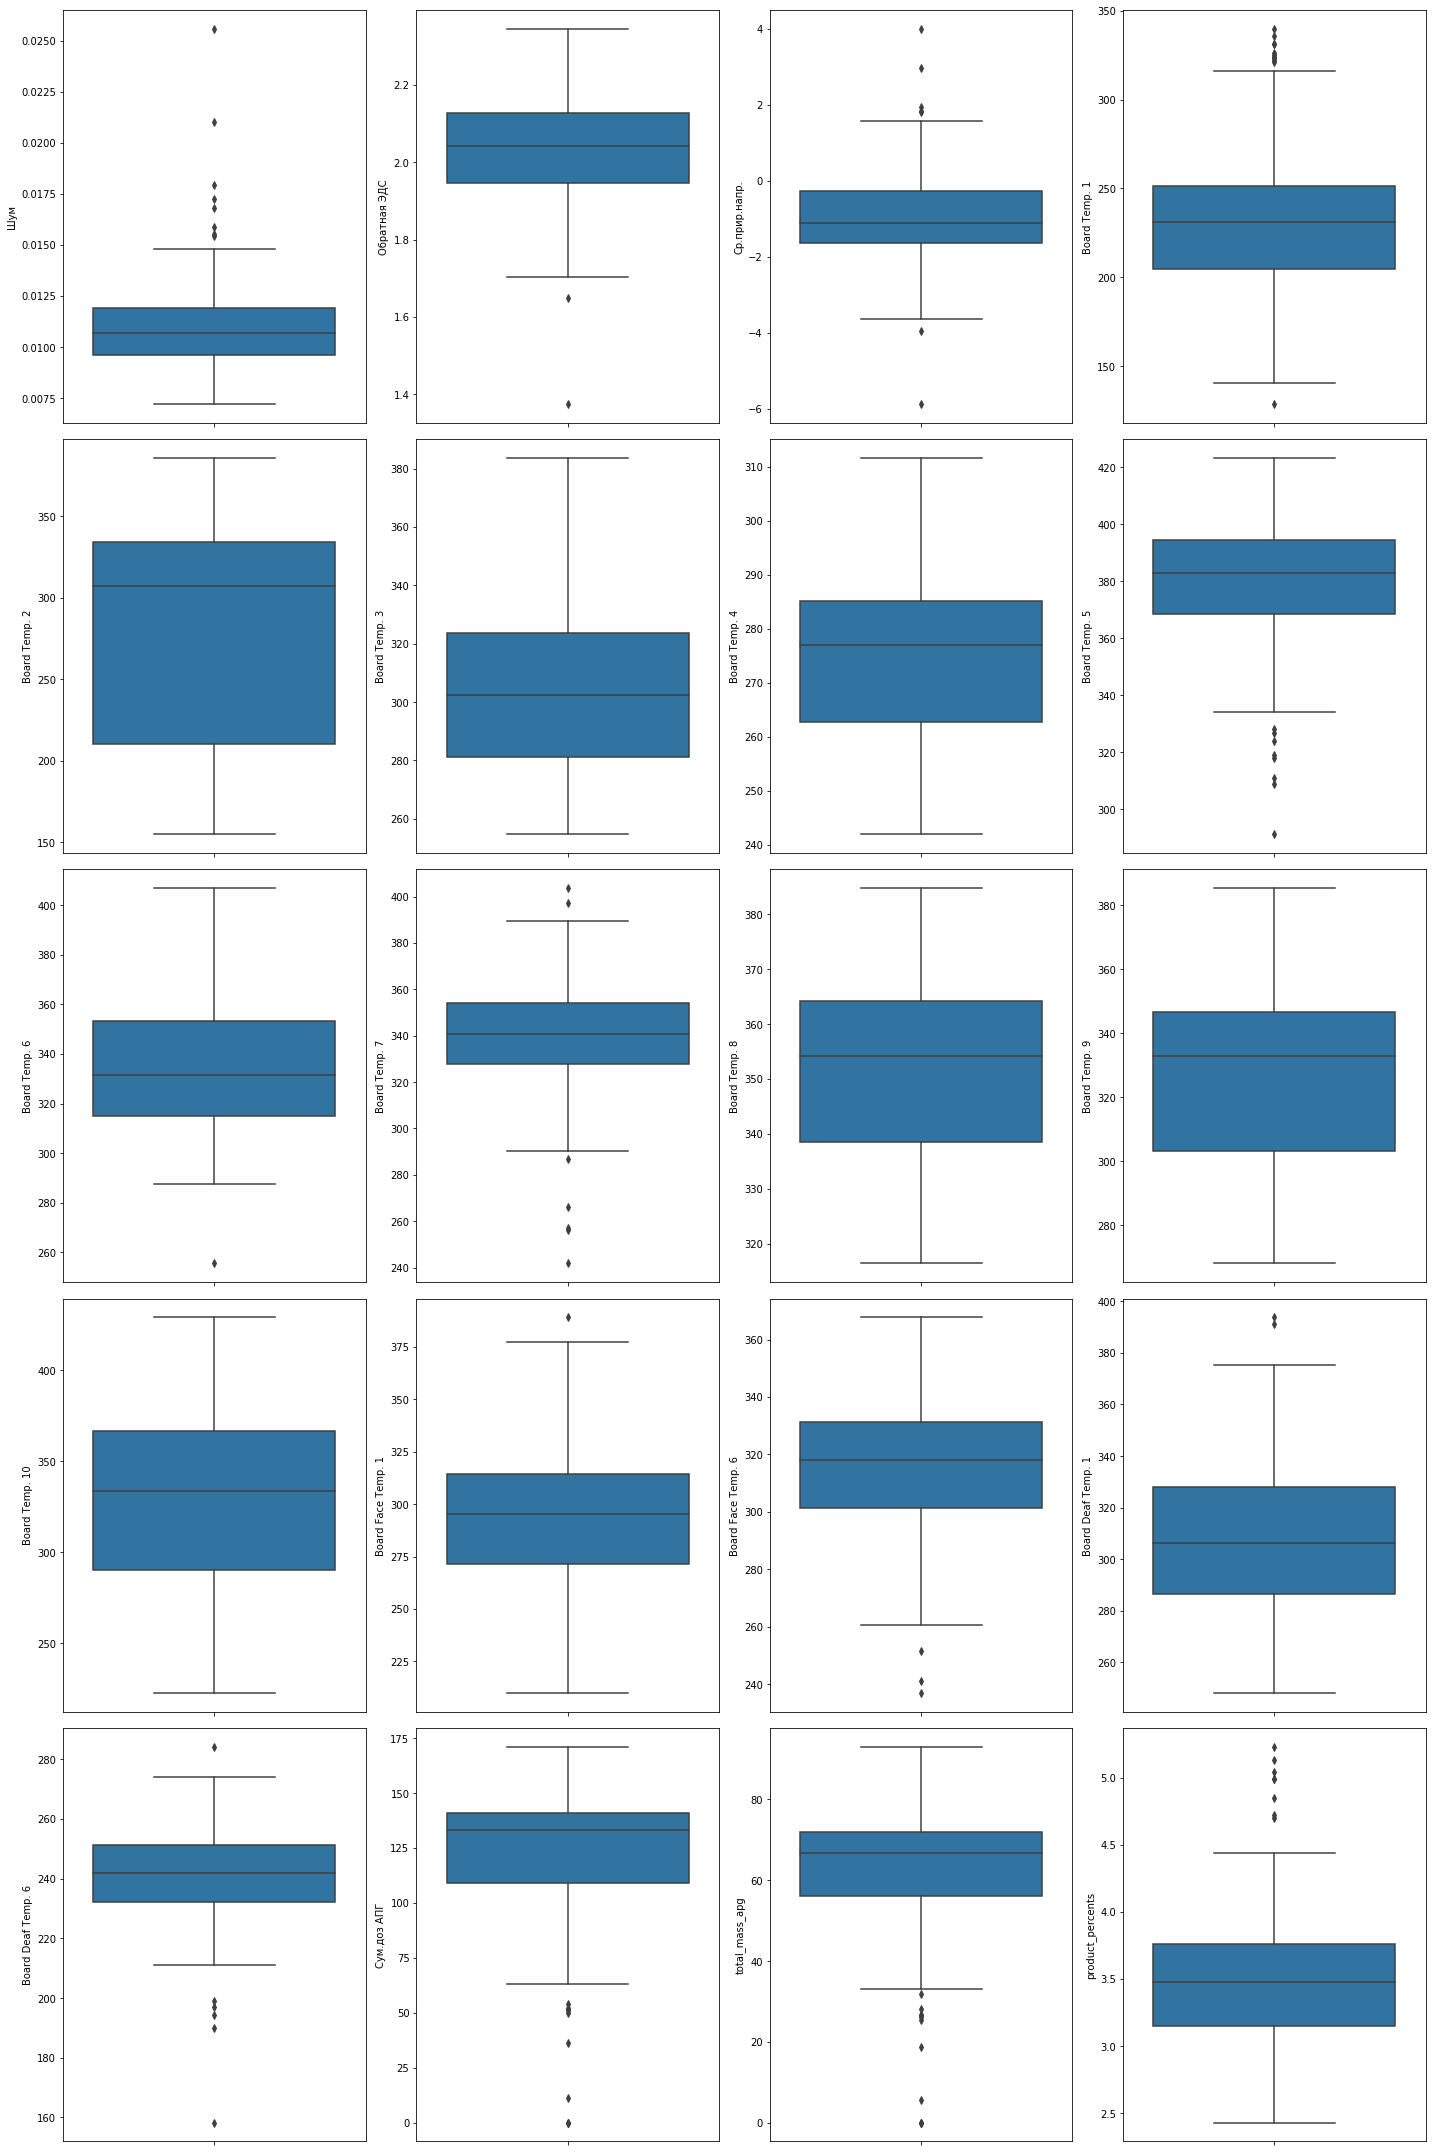

In [14]:
deep = final_df.copy()
deep = deep.drop('Date', axis=1)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 30))
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(y= deep.iloc[:, i], orient='v' , ax=ax)
fig.tight_layout();
plt.show()

Есть много выбросов. Отсортирую df по некоторым из признаков, посмотрю, как ведут себя остальные данные, когда сортирующий признак имеет необычное значение

In [15]:
final_df.sort_values(['Шум'])

,Date,Шум,Обратная ЭДС,Ср.прир.напр.,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,Board Temp. 6,...,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6,Сум.доз АПГ,total_mass_apg,product_percents
113,2018-09-25 14:00:00,0.007200,1.938250,-1.185000,323.900000,328.550000,277.500000,256.150000,373.650000,370.950000,...,341.600000,295.500000,362.850000,308.650000,342.100000,327.500000,247.750000,133.0,68.362,3.00
96,2018-09-17 05:00:00,0.007550,2.015000,-0.280000,241.500000,303.250000,287.600000,251.250000,372.400000,361.700000,...,333.600000,297.200000,352.750000,278.650000,330.450000,271.150000,254.450000,144.0,72.000,3.14
7,2018-08-03 14:00:00,0.007842,2.207895,1.842105,250.578947,354.315789,350.789474,287.315789,379.052632,315.684211,...,367.736842,355.105263,317.315789,276.421053,280.842105,329.421053,254.684211,52.0,26.520,4.72
114,2018-09-26 05:00:00,0.007900,2.073500,0.135000,310.700000,318.550000,268.100000,253.250000,387.750000,367.050000,...,341.950000,289.550000,365.800000,299.700000,338.750000,323.000000,238.750000,139.0,72.975,2.92
104,2018-09-21 05:00:00,0.007950,2.008600,-0.110000,231.050000,277.900000,264.450000,251.400000,378.100000,359.500000,...,328.150000,280.850000,346.400000,248.300000,331.200000,287.100000,238.050000,138.0,68.862,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2018-09-12 14:00:00,0.017950,1.900000,-1.655000,222.800000,310.550000,300.650000,249.000000,323.900000,331.150000,...,331.900000,318.000000,330.150000,275.900000,313.450000,273.150000,244.050000,143.0,72.215,3.02
101,2018-09-19 14:00:00,0.021000,2.017000,-1.430000,240.650000,282.350000,273.350000,248.700000,381.850000,356.750000,...,335.750000,293.350000,366.450000,282.050000,330.950000,293.800000,252.600000,135.0,69.660,3.39
35,2018-08-17 14:00:00,0.025600,2.041000,1.809091,255.650000,369.400000,324.250000,294.550000,409.700000,318.400000,...,372.750000,353.950000,404.450000,339.950000,320.400000,343.350000,247.850000,109.0,55.590,4.99
56,2018-08-28 05:00:00,NaN,NaN,NaN,247.800000,189.750000,318.400000,287.200000,397.450000,338.100000,...,363.200000,352.950000,321.850000,328.950000,329.850000,305.900000,252.650000,0.0,0.000,3.50


In [16]:
final_df.sort_values(['total_mass_apg'])

,Date,Шум,Обратная ЭДС,Ср.прир.напр.,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,Board Temp. 6,...,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6,Сум.доз АПГ,total_mass_apg,product_percents
57,2018-08-28 14:00:00,NaN,NaN,NaN,253.60,194.45,311.65,288.40,385.45,334.00,...,362.00,352.15,340.90,330.50,319.25,320.30,251.60,0.0,0.000,3.82
56,2018-08-28 05:00:00,NaN,NaN,NaN,247.80,189.75,318.40,287.20,397.45,338.10,...,363.20,352.95,321.85,328.95,329.85,305.90,252.65,0.0,0.000,3.50
39,2018-08-19 14:00:00,0.00905,2.23600,-0.565000,269.45,384.90,355.55,311.55,423.20,353.15,...,384.80,385.45,429.20,377.35,359.30,391.15,284.15,0.0,0.000,3.85
22,2018-08-11 05:00:00,0.01290,1.97985,-2.480000,243.85,356.55,350.65,289.45,400.85,324.50,...,369.90,343.50,409.60,328.45,305.90,342.15,249.85,11.0,5.610,3.57
36,2018-08-18 05:00:00,0.00985,2.12800,-2.090000,236.25,360.70,310.30,283.10,397.45,306.40,...,365.15,343.45,406.05,330.10,301.00,346.45,232.35,36.0,18.720,4.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2018-07-31 14:00:00,0.01590,2.07580,-1.400000,257.10,304.65,296.75,272.20,351.30,326.25,...,361.55,321.40,311.20,300.65,296.00,261.50,232.35,149.0,77.480,3.20
115,2018-09-26 14:00:00,0.00920,2.26400,-0.325000,321.25,323.10,269.05,252.05,387.35,373.45,...,340.95,291.45,368.20,312.90,343.65,330.40,243.35,152.0,79.800,3.12
0,2018-07-31 05:00:00,0.01160,2.34600,-1.155000,231.95,305.90,278.05,263.70,334.20,308.45,...,352.55,317.45,319.35,297.35,285.30,248.10,189.95,159.0,81.090,2.95
42,2018-08-21 05:00:00,0.01680,2.11300,0.820000,171.80,298.65,297.05,278.50,375.20,255.45,...,355.35,336.95,301.15,263.15,236.90,299.70,199.10,157.0,81.640,3.66


Не заметила закономерностей в поведении остальных признаков, когда по сортирующему был выброс, выбросы выглядят рандомно. Избавлюсь от выбросов 

In [17]:
for i in final_df.columns[1:-1]:
    perc_max = np.percentile(final_df[i], 95)
    perc_min = np.percentile(final_df[i], 5)
    final_df[i] = np.where(final_df[i] > perc_max, perc_max, final_df[i])
    final_df[i] = np.where(final_df[i] < perc_min, perc_min, final_df[i])

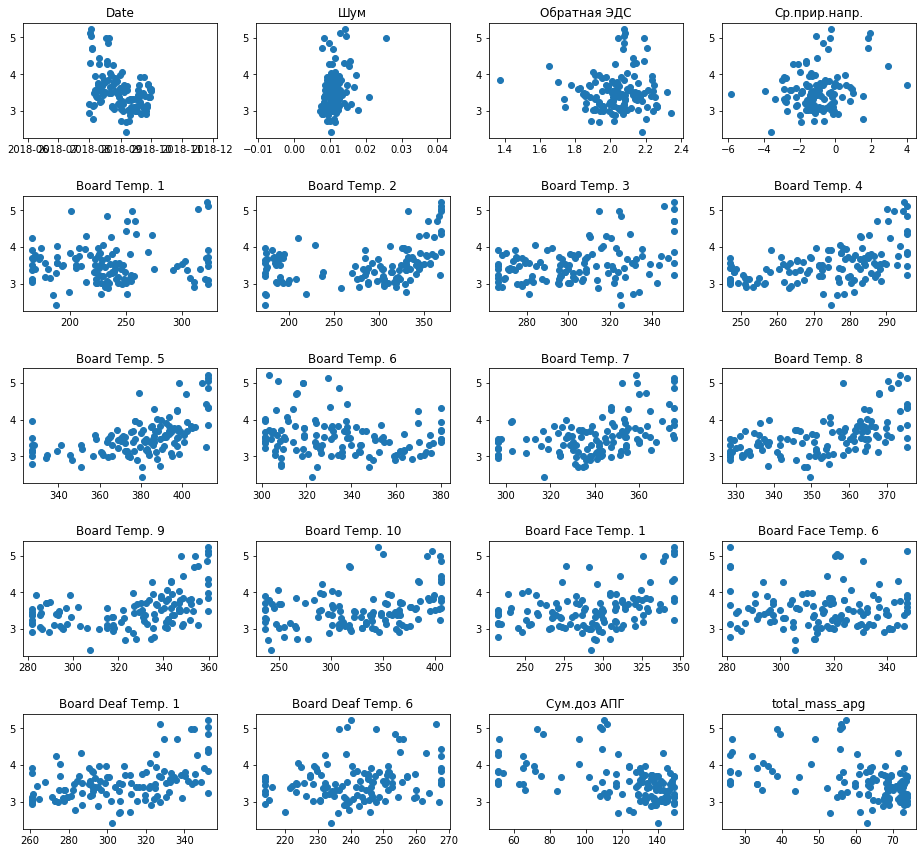

In [18]:
# Посмотрим зависимости признаков и таргета
fig=plt.figure(figsize=(16, 18))
for i, col in enumerate(final_df.drop(['product_percents'], axis=1).columns):
    ax=plt.subplot(6, 4, i + 1)
    ax.scatter(final_df[col], final_df['product_percents'])
    plt.title(col)
    plt.subplots_adjust(hspace=.5)

In [ ]:
sns.heatmap(final_df.corr())

In [ ]:
final_df.isna().sum() 
final_df = final_df.groupby(final_df.columns, axis = 1).transform(lambda x: x.fillna(x.mean()))

Строим модели. Т.к. данные датированы, я не могу воспользоваться train_test_split, они должны быть разделены стратефицировано с учетом дат, так что я разделю их вручную, после чего нормализую.
В качестве метрики для оценки работы моделей я выбрала MSE

In [ ]:
X, y = final_df.drop(['Date', 'product_percents'], axis=1), final_df['product_percents']
train_size = int(len(final_df) * 0.7)
X_train, X_test = X.loc[:train_size, :], X.loc[train_size:, :]
y_train, y_test = y.loc[:train_size], y.loc[train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Т.к. я планирую использовать несколько линейных моделей, для удобства напишу под их обучение и тест функцию

In [ ]:
linreg = LinearRegression()
ridge_cv = RidgeCV()
lasso_cv = LassoCV(random_state=43)

In [ ]:
def linear_models(model, X_train_scaled, X_test_scaled, y_train, y_test, feature_names=X.columns):
    model.fit(X_train_scaled, y_train)
    mse = mean_squared_error(y_test, model.predict(X_test_scaled))
    print("Train score: " + str(model.score(X_train_scaled, y_train)))
    print("Test score: " + str(model.score(X_test_scaled, y_test)))
    print("Train MSE: " + str(mean_squared_error(y_train, model.predict(X_train_scaled))))
    print("Test MSE: " + str(mse))
    print(pd.DataFrame(model.coef_, X.columns, columns=['coef']).sort_values(by='coef', ascending=False))
    plt.figure(figsize=(8, 4))
    plt.plot(model.predict(X_test_scaled), "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.legend(loc="best")
    plt.title(model)
    plt.grid(True)

In [ ]:
linear_models(linreg, X_train_scaled, X_test_scaled, y_train, y_test, feature_names=X.columns)

In [ ]:
linear_models(lasso_cv, X_train_scaled, X_test_scaled, y_train, y_test, feature_names=X.columns)

In [ ]:
linear_models(ridge_cv, X_train_scaled, X_test_scaled, y_train, y_test, feature_names=X.columns)

Линенйные модели, как и ожидалось, не очень хорошо сработали, данные коррелируют между собой, LassoCV поборолась с мультиколлинеарностью, занулив некоторые из коэффициентов.
Проверим как сработает случайный лес.

In [ ]:
forest = RandomForestRegressor(random_state=43)
forest.fit(X_train, y_train)
forest_mse_train = mean_squared_error(y_train, forest.predict(X_train))
forest_mse_test = mean_squared_error(y_test, forest.predict(X_test))
print(pd.DataFrame(forest.feature_importances_, X.columns, columns=['importance']).sort_values
      (by='importance', ascending=False))
print('MSE случайного леса на train - ' + str(forest_mse_train))
print('MSE случайного леса на test - ' + str(forest_mse_test))

In [ ]:
np.sqrt(forest_mse_test)